In [1]:
import dash, math, datetime as dt, pandas as pd
from dash.dependencies import Input, Output, State, ClientsideFunction
from dash import dcc, html
import dash_bootstrap_components as dbc
from dash_bootstrap_templates import load_figure_template
import plotly
import plotly.io as pio
import plotly.graph_objects as go 
import plotly.figure_factory as ff
import plotly.express as px
import datetime    
import utils
from tqdm import tqdm 
tqdm.pandas()
import spacy
nlp = spacy.load('pt_core_news_sm')

%load_ext autoreload
%autoreload 2
import figures, main_etl, extract_data, transform_data

# Seaborn colors  
# ['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', 
# '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']    

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
from github import Github
from zenhub import Zenhub

with open('tokens.txt') as f:
     git_token, zh_token = [line.rstrip('\n') for line in f.readlines()]    
        
zh = Zenhub(zh_token)
g = Github(git_token)

repo_id='357557193'    
repo_C01 = g.get_repo("MPMG-DCC-UFMG/C01")
repo_F01 = g.get_repo("MPMG-DCC-UFMG/F01")

## Update Dados Coleta

In [ ]:
%%time 

main_etl.update_data_coletas(git_token, zh_token) # 8min 33s
# main_etl.update_data_desenvolvimento(git_token, zh_token)

## Clusterização de portais

### Diferenças entre fontes

In [110]:
planilha = pd.read_csv('data/Portais x Templates - links_validados.csv', 
                       usecols=['#Rank', 'Município','Desenvolvedor', 
                                'Portal da Transparência (validado)']
                      ).sort_values('#Rank')
print('Planilha:', planilha.shape)
display(planilha.head())

clustering = pd.read_csv('data/municipios_clusters.csv',
                        usecols=['municipio', 'template_name_size',
                                 'template', 'cluster_id'])
print('Clustering:', clustering.shape)
display(clustering.head())

Planilha: (853, 4)


,#Rank,Município,Desenvolvedor,Portal da Transparência (validado)
65,1,Belo Horizonte,prefeitura,https://transparencia.pbh.gov.br/
824,2,Uberlândia,prefeitura,https://www.uberlandia.mg.gov.br/portal-da-tra...
205,3,Contagem,prefeitura,http://www.contagem.mg.gov.br/transparencia/
418,4,Juiz de Fora,prefeitura,https://www.pjf.mg.gov.br/transparencia/
71,5,Betim,prefeitura,http://www.betim.mg.gov.br/transparencia/


Clustering: (837, 4)


,municipio,template_name_size,template,cluster_id
0,Alvorada de Minas,Síntese Tecnologia e Informática (88),Síntese Tecnologia e Informática,5
1,Aricanduva,Síntese Tecnologia e Informática (88),Síntese Tecnologia e Informática,5
2,Augusto de Lima,Síntese Tecnologia e Informática (88),Síntese Tecnologia e Informática,5
3,Berilo,Síntese Tecnologia e Informática (88),Síntese Tecnologia e Informática,5
4,Bocaiúva,Síntese Tecnologia e Informática (88),Síntese Tecnologia e Informática,5


In [111]:
# pre-processing
clustering.template = clustering.template.str.normalize('NFKD').str.encode(
    'ascii', errors='ignore').str.decode('utf-8')
clustering.template = clustering.template.str.lower()
clustering.template = clustering.template.str.replace(' ', '')
planilha.Desenvolvedor = planilha.Desenvolvedor.str.lower()
planilha.Desenvolvedor = planilha.Desenvolvedor.str.replace(' ', '')
clustering.template = clustering.template.fillna('sem_nome_no_clustering')

clustering.loc[clustering.municipio == 'Pingo d\'Água', 'municipio'] = 'Pingo-d\'Água'
clustering.loc[clustering.municipio == 'São Thomé das Letras', 'municipio'] = 'São Tomé das Letras'

# merge
merged = pd.merge(planilha, clustering, left_on='Município', right_on='municipio', how='outer')
merged

,#Rank,Município,Desenvolvedor,Portal da Transparência (validado),municipio,template_name_size,template,cluster_id
0,1,Belo Horizonte,prefeitura,https://transparencia.pbh.gov.br/,Belo Horizonte,Template1 (9),template1,24.0
1,2,Uberlândia,prefeitura,https://www.uberlandia.mg.gov.br/portal-da-tra...,Uberlândia,NaN,sem_nome_no_clustering,403.0
2,3,Contagem,prefeitura,http://www.contagem.mg.gov.br/transparencia/,Contagem,NaN,sem_nome_no_clustering,772.0
3,4,Juiz de Fora,prefeitura,https://www.pjf.mg.gov.br/transparencia/,Juiz de Fora,NaN,sem_nome_no_clustering,63.0
4,5,Betim,prefeitura,http://www.betim.mg.gov.br/transparencia/,Betim,NaN,sem_nome_no_clustering,651.0
...,...,...,...,...,...,...,...,...
848,849,São Sebastião do Rio Preto,prefeitura,http://saosebastiaodoriopreto.mg.gov.br/transp...,São Sebastião do Rio Preto,NaN,sem_nome_no_clustering,66.0
849,850,Senador José Bento,portalfacil,http://www.transparenciafacil.com.br/0211202,Senador José Bento,Portal Fácil (46),portalfacil,2.0
850,851,Grupiara,404,http://179.189.0.196:8444/transparencia/,NaN,NaN,NaN,NaN
851,852,Cedro do Abaeté,adpm,http://www.adpmnet.com.br/index.php?option=com...,Cedro do Abaeté,ADPM (22),adpm,28.0


In [115]:
conflicts = merged[merged.Desenvolvedor != merged.template]
conflicts = conflicts[['#Rank', 'Município', 'municipio', 'Desenvolvedor', 'template', 'template_name_size', 
                       'cluster_id', 'Portal da Transparência (validado)']]
conflicts = conflicts.rename(columns={'Município': 'Municipio (Planilha)',
                                      'municipio': 'Municipio (Clustering)',
                                      'Desenvolvedor': 'Desenvolvedor (Planilha)',
                                      'template': 'Template (Clustering)'}) 
conflicts = conflicts.sort_values(['Desenvolvedor (Planilha)', 'Municipio (Planilha)'])                                      
conflicts.to_csv('data/conflitos_templates.csv', index=False)
conflicts

,#Rank,Municipio (Planilha),Municipio (Clustering),Desenvolvedor (Planilha),Template (Clustering),template_name_size,cluster_id,Portal da Transparência (validado)
357,358,Delta,Delta,3gdelta,sem_nome_no_clustering,NaN,29.0,http://www.delta.mg.gov.br/portal-da-transpare...
372,373,Itamogi,Itamogi,3gnet,sem_nome_no_clustering,NaN,162.0,https://itamogi.mg.gov.br/transparencia/
457,458,Limeira do Oeste,Limeira do Oeste,3gnet,sem_nome_no_clustering,NaN,470.0,https://limeiradooeste.mg.gov.br/portal-da-tra...
404,405,Monsenhor Paulo,Monsenhor Paulo,3gnet,sem_nome_no_clustering,NaN,492.0,https://camaramonsenhorpaulo.mg.gov.br/portal-...
596,597,Senador Amaral,Senador Amaral,3gnet,sem_nome_no_clustering,NaN,563.0,https://senadoramaral.mg.gov.br/portal-da-tran...
...,...,...,...,...,...,...,...,...
227,228,Tocantins,Tocantins,wms,sem_nome_no_clustering,NaN,30.0,https://tocantins.mg.gov.br/transparencia/
89,90,Boa Esperança,Boa Esperança,NaN,betha,Betha (7),64.0,https://e-gov.betha.com.br/transparencia/01037...
164,165,Carmo do Cajuru,Carmo do Cajuru,NaN,betha,Betha (7),64.0,https://e-gov.betha.com.br/transparencia/01037...
172,173,Monte Alegre de Minas,NaN,NaN,NaN,NaN,NaN,http://187.72.215.252:8080/dadosweb/loginWeb.j...


,#Rank,Município,Desenvolvedor,Portal da Transparência (validado),municipio,template_name_size,template,cluster_id
11,12.0,Divinópolis,grp,http://177.69.246.151:8090/portalcidadao/#efb3...,NaN,NaN,NaN,NaN
147,148.0,São João da Ponte,colorlib,https://saojoaodaponte.mg.gov.br/transparencia,NaN,NaN,NaN,NaN
172,173.0,Monte Alegre de Minas,NaN,http://187.72.215.252:8080/dadosweb/loginWeb.j...,NaN,NaN,NaN,NaN
211,212.0,Lagoa Formosa,404,http://transparencia.lagoaformosa.mg.gov.br:84...,NaN,NaN,NaN,NaN
217,218.0,Bom Sucesso,memory,http://lai.memory.com.br/entidades/login/98CSD1,NaN,NaN,NaN,NaN
274,275.0,Ibiraci,portal facil,http://ibiraci.mg.gov.br/portal-da-transparencia/,NaN,NaN,NaN,NaN
351,352.0,Miradouro,404,https://prefeitura24horas.online/_transparenci...,NaN,NaN,NaN,NaN
481,482.0,São Tomé das Letras,fiorilli,https://portal.sgpcloud.net:9016/transparencia/,NaN,NaN,NaN,NaN
490,491.0,Iraí de Minas,404,http://177.85.2.36:8444/transparencia/,NaN,NaN,NaN,NaN
515,516.0,Dona Euzébia,404,https://prefeitura24horas.online/_transparenci...,NaN,NaN,NaN,NaN


In [58]:
import json

with open('data/clusters.d3.json', 'r') as f:
     clusters_json = json.loads(f.read())

In [59]:
clusters_json['children'][:2]

[{'size': 10.0,
  'children': [{'size': 10.0, 'name': '146', 'index': 146}],
  'name': '146',
  'index': 146},
 {'size': 20.0,
  'children': [{'size': 10.0, 'name': '476', 'index': 476},
   {'size': 10.0, 'name': '227', 'index': 227}],
  'name': '227',
  'index': 227}]

In [73]:
clusters.dtypes

cluster_id      object
cluster_size     int64
municipio_id    object
dtype: object

In [88]:
import numpy as np
clusters = []

for cluster in clusters_json['children']:
    for municipio in cluster['children']:
        new_row = [int(cluster['name']), int(cluster['size']/10), int(municipio['name'])]
        clusters.append(new_row) 
        
clusters = pd.DataFrame(clusters, columns=['cluster_id', 'cluster_size', 'municipio_id'])
clusters

,cluster_id,cluster_size,municipio_id
0,146,1,146
1,227,2,476
2,227,2,227
3,92,1,92
4,514,1,514
...,...,...,...
832,0,11,481
833,0,11,359
834,0,11,384
835,0,11,457


In [65]:
municipios = pd.read_csv('data/part-00000', names=['municipio_id', 'html'])
municipios['nome'] = municipios['html'].apply(lambda x: x.split('/')[-1][:-5])

municipios

,municipio_id,html,nome
0,0,/home/pedro/MPMG/html_saver/Conceição do Rio V...,Conceição do Rio Verde
1,1,/home/pedro/MPMG/html_saver/Rio Novo.html,Rio Novo
2,2,/home/pedro/MPMG/html_saver/Cachoeira de Minas...,Cachoeira de Minas
3,3,/home/pedro/MPMG/html_saver/Rio Casca.html,Rio Casca
4,4,/home/pedro/MPMG/html_saver/Periquito.html,Periquito
...,...,...,...
832,832,/home/pedro/MPMG/html_saver/Monte Santo de Min...,Monte Santo de Minas
833,833,/home/pedro/MPMG/html_saver/Prados.html,Prados
834,834,/home/pedro/MPMG/html_saver/Buritizeiro.html,Buritizeiro
835,835,/home/pedro/MPMG/html_saver/Formoso.html,Formoso


In [69]:
cluster_template = pd.read_csv('data/cluster-template.csv')
cluster_template['name_size'] = cluster_template.template + ' (' + cluster_template['n_portais'].astype(str) + ')' 
cluster_template.head()

,rank,cluster_id,template,n_portais,name_size
0,1,5,Síntese Tecnologia e Informática,88,Síntese Tecnologia e Informática (88)
1,2,7,Memory,66,Memory (66)
2,3,1,Siplanweb,61,Siplanweb (61)
3,4,17,Portaltp,61,Portaltp (61)
4,5,6,Portal Fácil,60,Portal Fácil (60)


In [121]:
import json

def build_municipios_clusters_df(clusters_json_path, part_0000_path, cluster_template_path):
    with open(clusters_json_path, 'r') as f:
         clusters_json = json.loads(f.read())

    municipios = []
    for cluster in clusters_json['children']:
        for municipio in cluster['children']:
            new_row = [int(municipio['name']), int(cluster['name']), int(cluster['size']/10)]
            municipios.append(new_row) 
            
    municipios = pd.DataFrame(municipios, columns=['municipio_id', 'cluster_id', 'cluster_size'],
                            dtype=int)

    nomes_municipios = pd.read_csv(part_0000_path, names=['municipio_id', 'municipio'])
    nomes_municipios['municipio'] = nomes_municipios['municipio'].apply(lambda x: x.split('/')[-1][:-5])        
    municipios = municipios.merge(nomes_municipios, on='municipio_id', how='left')

    cluster_template = pd.read_csv(cluster_template_path)
    cluster_template['template_name_size'] = cluster_template.template + \
        ' (' + cluster_template.cluster_n_portais.astype(str) + ')' 
    municipios = municipios.merge(cluster_template, on='cluster_id', how='left')
    
    municipios = municipios.sort_values(['cluster_size', 'template', 'municipio'], 
                                        ascending=[False, True, True])
    municipios = municipios[['municipio_id', 'municipio', 'template', 
                             'cluster_id',	'cluster_size',	'cluster_rank',
                             'cluster_n_portais', 'template_name_size']]
    
    return municipios

#------------------------------------------

municipios = build_municipios_clusters_df('data/clusters.d3.json', 'data/part-00000', 'data/cluster-template.csv')
municipios.to_csv('data/municipios_clusters.csv', index=False)
municipios

,municipio_id,municipio,template,cluster_id,cluster_size,cluster_rank,cluster_n_portais,template_name_size
240,176,Alvorada de Minas,Síntese Tecnologia e Informática,5,88,1.0,88.0,Síntese Tecnologia e Informática (88)
247,759,Aricanduva,Síntese Tecnologia e Informática,5,88,1.0,88.0,Síntese Tecnologia e Informática (88)
259,726,Augusto de Lima,Síntese Tecnologia e Informática,5,88,1.0,88.0,Síntese Tecnologia e Informática (88)
270,666,Berilo,Síntese Tecnologia e Informática,5,88,1.0,88.0,Síntese Tecnologia e Informática (88)
201,148,Bocaiúva,Síntese Tecnologia e Informática,5,88,1.0,88.0,Síntese Tecnologia e Informática (88)
...,...,...,...,...,...,...,...,...
26,403,Uberlândia,NaN,403,1,NaN,NaN,NaN
137,47,Varjão de Minas,NaN,47,1,NaN,NaN,NaN
614,141,Vazante,NaN,141,1,NaN,NaN,NaN
301,809,Verdelândia,NaN,809,1,NaN,NaN,NaN


In [120]:
municipios[(municipios.cluster_size != municipios.cluster_n_portais) 
           & (municipios.cluster_n_portais.notna())]

,municipio_id,municipio,template,cluster_id,cluster_size,cluster_rank,cluster_n_portais,template_name_size


In [124]:
municipios[municipios.template == 'Betha']['municipio'].values

,municipio_id,municipio,template_name_size,template,cluster_id,cluster_size,cluster_rank,cluster_n_portais
703,98,Alterosa,Betha (26),Betha,3,26,10.0,26.0
720,364,Alto Rio Doce,Betha (26),Betha,3,26,10.0,26.0
698,81,Bandeira do Sul,Betha (26),Betha,3,26,10.0,26.0
704,607,Botelhos,Betha (26),Betha,3,26,10.0,26.0
709,158,Campos Gerais,Betha (26),Betha,3,26,10.0,26.0
699,597,Cataguases,Betha (26),Betha,3,26,10.0,26.0
719,23,Cláudio,Betha (26),Betha,3,26,10.0,26.0
695,233,Congonhas,Betha (26),Betha,3,26,10.0,26.0
696,625,Formiga,Betha (26),Betha,3,26,10.0,26.0
712,347,Ijaci,Betha (26),Betha,3,26,10.0,26.0


## Gráficos Semanais

In [188]:
df = pd.read_csv("data/df.csv")
week_status = count_by_week(df, time_column='closed_at')
week_status.head(15)

,week_year,closed_at,week,year
0,1/2022,56.0,1,2022
1,2/2022,70.0,2,2022
2,3/2022,63.0,3,2022
3,4/2022,55.0,4,2022
4,5/2022,5.0,5,2022
5,6/2022,91.0,6,2022
6,7/2022,65.0,7,2022
7,8/2022,188.0,8,2022
8,9/2022,124.0,9,2022
9,10/2022,232.0,10,2022


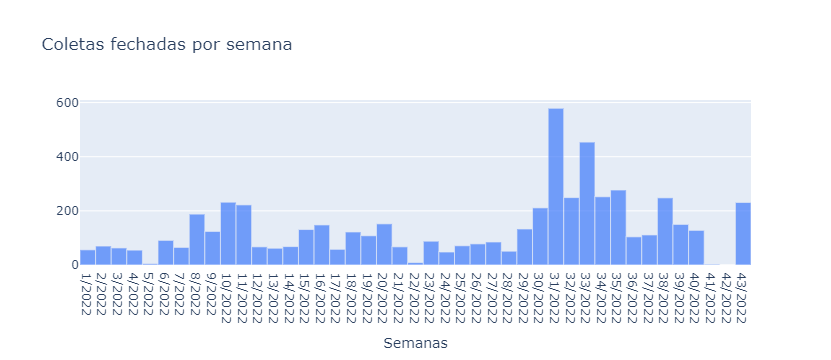

In [190]:
# week_status = pd.read_csv('data/week_status.csv')    
figures.plot_status_week(week_status, title='Coletas fechadas por semana',
    y_column='closed_at', x_column='week_year',
    xaxis_title_text='Semanas') 

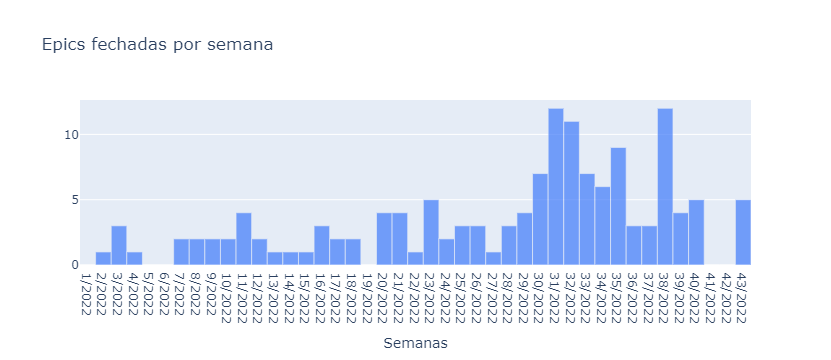

In [191]:
#TODO pq 8 ao inves de 10
count_epics_week = pd.read_csv("data/count_epics_week.csv")

figures.plot_status_week(
    count_epics_week, title='Epics fechadas por semana',
    y_column='Coletado', x_column='week_year', xaxis_title_text='Semanas')

## Gráfico com Previsões

,week_year,Coletado,Não coletável,closed,week,year
0,1/2022,0.0,0.0,0.0,1,2022
1,2/2022,1.0,0.0,1.0,2,2022
2,3/2022,3.0,0.0,3.0,3,2022
3,4/2022,1.0,1.0,2.0,4,2022
4,5/2022,0.0,0.0,0.0,5,2022
5,6/2022,0.0,0.0,0.0,6,2022
6,7/2022,2.0,0.0,2.0,7,2022
7,8/2022,2.0,0.0,2.0,8,2022
8,9/2022,2.0,0.0,2.0,9,2022
9,10/2022,2.0,0.0,2.0,10,2022


coletado_por_mes_anterior: 25.0, previsao_mes_anterior:
  [135.0, 160.0, 185.0, 210.0, 235.0, 260.0, 285.0, 310.0, 335.0, 360.0]
coletado_por_mes_atualizado: 10.0, previsao_atual:
  [135.0, 145.0, 155.0, 165.0, 175.0, 185.0, 195.0, 205.0, 215.0, 225.0]


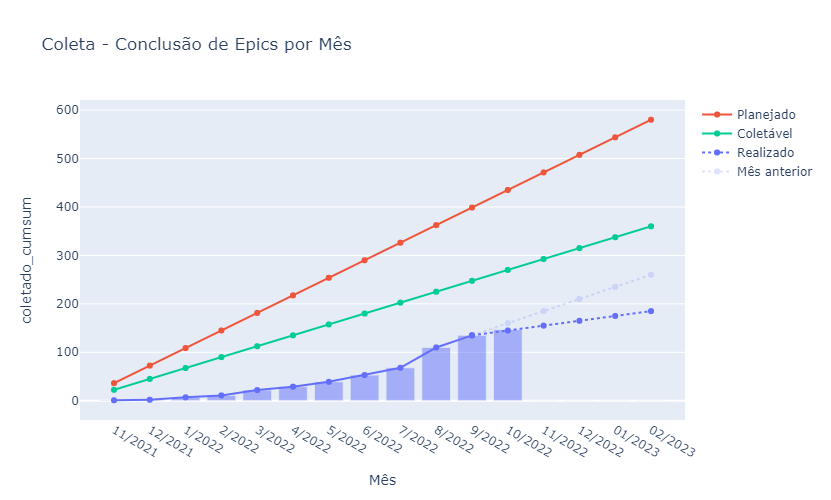

In [204]:
#TODO atualizar estimativa de coletável
def plot_speed_epics(df, df_week, title):      
    
    df['coletado_cumsum'] = df['Coletado'].cumsum()   
    coletado_cumsum_anterior = df['coletado_cumsum'][:-1].values.tolist()
    # df["closed_cumsum"] = df["closed"].cumsum()             
    # df["naocoletado_cumsum"] = df["Não coletável"].cumsum()  
    
    display(df_week)
    
    total_coletado_mes_anterior  = df['Coletado'][:-1].sum()
    coletado_por_mes_atualizado = df_week['Coletado'][-4:].sum()  #df["Coletado"].mean()
    coletado_por_mes_anterior   = df['Coletado'][-2:-1].values[0]
    # fechado_por_mes = df["closed"].mean()      
    # total_coletado  = df['Coletado'].sum()

    #TODO numbers
    previsao_mes_anterior = [total_coletado_mes_anterior + (i * coletado_por_mes_anterior) for i in range(10)]
    previsao_atual = [total_coletado_mes_anterior + (i * coletado_por_mes_atualizado) for i in range(10)]
    
    print(f'coletado_por_mes_anterior: {coletado_por_mes_anterior}, previsao_mes_anterior:\n  {previsao_mes_anterior}')
    print(f'coletado_por_mes_atualizado: {coletado_por_mes_atualizado}, previsao_atual:\n  {previsao_atual}')
    
    # Definindo os meses de interesse
    df = df.merge( pd.DataFrame(["11/2021", "12/2021"] + [f'{x}/2022' for x in range(1,13)] + 
                                ["01/2023", "02/2023"], columns=["month_year"]), how="right").fillna(0)    
    
    # Baselines
    n_templates = 15 + 5            # 15 + 5 municipios
    total_epics_by_template = 29    # Siplanweb    
    
    total_epics = total_epics_by_template * n_templates    
    total_months = df.shape[0]
    ideal_speed = total_epics / total_months
    
    media_nao_coletavel = (12 + 12 + 12 + 8) / 4   # Siplanweb + Betha + MunicipalNet + ADPM    
    total_coletaveis = total_epics - (media_nao_coletavel * n_templates)
    ideal_speed_discounted = total_coletaveis / total_months
    
    # Plot
    fig =  px.bar(df, x="month_year", y='coletado_cumsum', title=title, opacity=0.5, height=500, width=1000,
                 labels={"value":"Epics concluídas (acumulado)", "month_year":"Mês", 'variable':''})

    fig.update_layout(yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 100))
    fig.add_traces([
        go.Scatter(x=df.month_year, y=[i * ideal_speed for i in range(1, total_months+1)], name="Planejado", opacity=1,
                  line=go.scatter.Line(color='#ef553b')), #color="red" ff6692 ef553b     
        go.Scatter(x=df.month_year, y=[i * ideal_speed_discounted for i in range(1, total_months+1)], name="Coletável",
                  line=go.scatter.Line(color="#00CC96")), #AB63FA
        go.Scatter(x=df.month_year, y=coletado_cumsum_anterior, name="Realizado", 
                  line=go.scatter.Line(dash='solid', color="#636efa"), opacity=1, showlegend=False), 
        go.Scatter(x=df.month_year[-6:], y=previsao_atual, name="Realizado", 
                  line=go.scatter.Line(dash='dot', color="#636efa"), opacity=1),
        go.Scatter(x=df.month_year[-6:], y=previsao_mes_anterior, name="Mês anterior",
                  line=go.scatter.Line(dash='dot', color="#636efa"), opacity=0.2),
        # go.Scatter(x=df.month_year, y=[i * velocidade_coleta for i in range(1, total_months+1)], name="Realizado",
        #           line=go.scatter.Line(color="#636efa"), opacity=1),#, text=df), #8c86ff
        # go.Scatter(x=df.month_year, y=mes_anterior, name="Mês anterior",
        #           line=go.scatter.Line(color="#636efa"), opacity=0.2),
        # go.Scatter(x=df.month_year, y=[i * velocidade_total for i in range(1, total_months+1)], name="Total Fechado",
        #           line=go.scatter.Line(color="blue"), opacity=0.1),    # Inclui todas epics fechadas
                    # dash -> ['solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot']
    ])
    
    return fig

#-------------------------------------------------------------------------------------
#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', 
# '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd'

count_epics_month = pd.read_csv("data/count_epics_month.csv")
count_epics_week  = pd.read_csv("data/count_epics_week.csv")

count_epics_month = count_epics_month[count_epics_month.month_year != '11/2022'] #TODO 
plot_speed_epics(count_epics_month, count_epics_week, title='Coleta - Conclusão de Epics por Mês') 


In [ ]:
repo = repo_F01
epics_id = [1928, 1645, 1935, 1330, 1964, 1963, 1905]

epics_info, count_epics_month, count_epics_week = transform_data.summarize_epics(epics_id, repo_F01)
count_epics_month, count_epics_week

## Gráfico de Visão Geral

In [207]:
epics_df.template.unique()

array(['ADPM (22)', 'Síntese tecnologia e informatica (88)', 'ABO (21)',
       'Template1 (22)', 'GRP (27)', 'Memory (66)', 'Portaltp (61)',
       'PT (45)', 'Betha (26)', 'Siplanweb (61)', 'Fiorilli (7)',
       'Template1 (9)', 'Portal Facil (5)', 'Portal Facil (46)',
       'Portal Facil (60)', nan, 'Template2 (28)', 'Habeas Data (7)',
       'Municipal Net (11)', 'Prefeitura'], dtype=object)

['Síntese tecnologia e informatica (88)' 'Memory (66)' 'Siplanweb (61)'
 'Portaltp (61)' 'Portal Facil (60)' 'Portal Facil (46)' 'PT (45)'
 'Template2 (28)' 'GRP (27)' 'Betha (26)' 'Template1 (22)' 'ADPM (22)'
 'ABO (21)' 'Municipal Net (11)' 'ADPM (7)' 'Belo Horizonte' 'Contagem'
 'Uberlândia' 'Juiz de Fora' 'Betim']


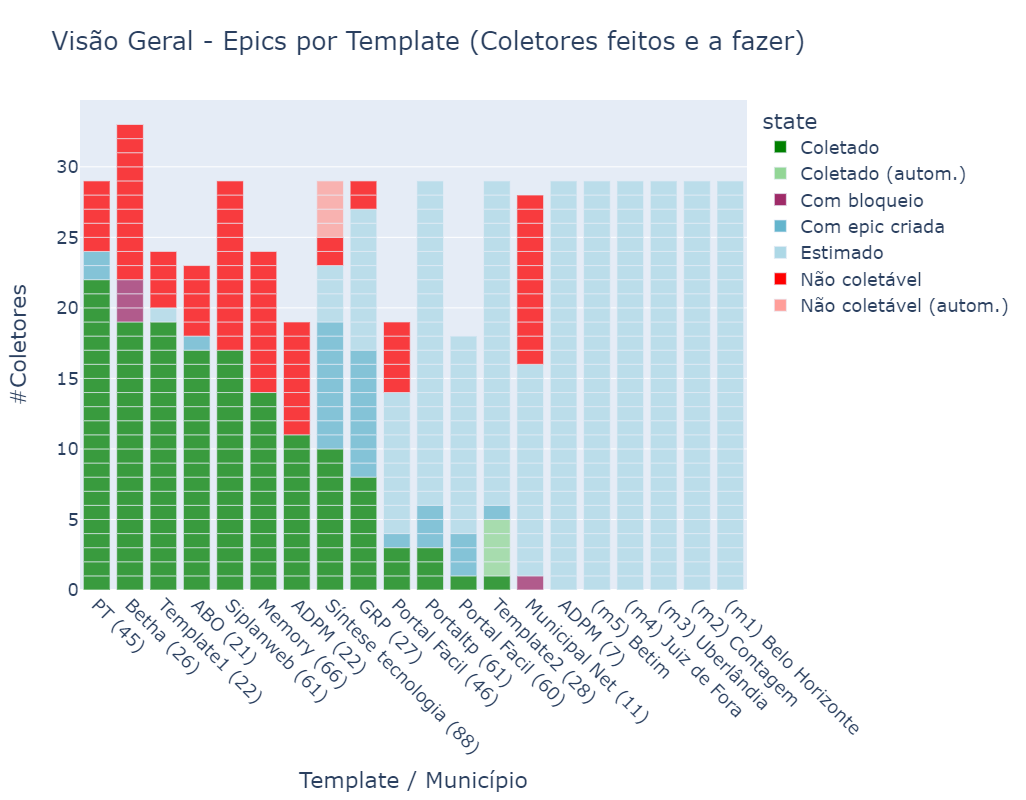

In [222]:
# TODO melhorar automacao
def plot_status_epics(df, top_templates, sondagem, title='Visão Geral - Epics por Template (Coletores feitos e a fazer)'):

    # resultados do buscador de subtags (sondagem)
    # templates_ja_analisados = ['ADPM', 'Betha', 'Municipal Net', 'Siplanweb', 'Memory']
    templates_ja_analisados = [
        'ADPM (22)', 'Betha (26)', 'Municipal Net (11)', 'Siplanweb (61)', 'Memory (66)', 
        'Template1 (22)', 'Portal Facil (60)', 'Portal Facil (46)']
    s = sondagem[sondagem == 0].count(axis=1)
    s = s[s != 0]
    s = s.drop(templates_ja_analisados)
    s = s.sort_index()
    nao_loc_autom = dict(s)
    
    # Fonte: Planilha Controle de Dados (#TODO transformar em Epics com "não-localizado")
    nao_loc_manual = {'Municipal Net (11)': 12, 'Portal Facil (46)': 5}
    coletado_autom = {'Template2 (28)': 4}
    
    for template, count in nao_loc_autom.items():
        for i in range(count):
            df = df.append({'template':template, 'state':'Não coletável (autom.)', 'aux':1}, ignore_index=True)
            
    for template, count in nao_loc_manual.items():
        for i in range(count):
            df = df.append({'template':template, 'state':'Não coletável', 'aux':1}, ignore_index=True)
            
    for template, count in coletado_autom.items():
        for i in range(count):
            df = df.append({'template':template, 'state':'Coletado (autom.)', 'aux':1}, ignore_index=True)
       
    # Pre-process dataframes       
    count_col = 'aux'
    name_col  = 'shortname'
    top_templates = top_templates[top_templates['rank'] <= 15]
    df = top_templates.merge(df, how='left').fillna({'state':'Estimado', count_col:1})   
    templates = df['template'].dropna().unique() 
    
    print(templates)
    
    # TODO usar arquivo separado
    total_ref = 29  # Siplanweb  
    total = dict.fromkeys(templates, total_ref)
    total['Municipal Net (11)'] = 28
    total['Betha (26)'] = 33
    total['ADPM (22)'] = 19
    total['PT (45)'] = 28
    total['Memory (66)'] = 23
    total['ABO (21)'] = 23
    total['Template1 (22)'] = 24
    total['Portal Facil (60)'] = 18
    total['Portal Facil (46)'] = 19
    
    # Fill missing (estimated) epics in df
    for template in templates:        
        created =  df.groupby('template').count()['state'][template]
        missing = total[template] - created
        size = df[df.template == template]['size'].values[0]
        name = df[df.template == template][name_col].values[0]

        for i in range(missing):            
            df = df.append({'template':template, 'state':'Estimado', name_col:name,
                            'size':size, count_col:1}, ignore_index=True)           
        
    df = df.sort_values(by=['state', name_col], ascending=[True,False])
    xorder = df.groupby(['state', name_col]).count()['aux'][
        'Coletado'].sort_values(ascending=False).index.tolist()

    # Plot
    fig = px.bar(
        df, y=count_col, x=name_col, color='state', height=800, width=1100, title=title,
        color_discrete_map = {
            'Coletado':'green', 
            'Coletado (autom.)':'#92d696', 
            'Com bloqueio':'#9F2B68',
            'Com epic criada':'#64b5cd', 
            'Estimado':'lightblue', 
            'Não coletável':'red', 
            'Não coletável (autom.)':'#ff9e99'}, 
        labels = {
            count_col:"#Coletores", 
            name_col:"Template / Município"}, 
        opacity = 0.75 )    
    
    fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':xorder})
    fig.update_xaxes(tickangle=45)
    fig.update_layout(font=dict(size=18))    
    
    return fig

#-------------------------------------------------------------

epics_df = pd.read_csv("data/epics.csv")
top_templates = pd.read_csv("data/top_templates.csv")
sondagem = pd.read_csv('data/resultados_templates.csv', index_col=0).astype(int)

fig = plot_status_epics(epics_df, top_templates, sondagem)    
fig.write_image('./fig/status-coleta.png', scale=1)
fig


In [74]:
# TODO completar issues sem labels (branco)

### Consulta de Issues/Epics

In [4]:
i = repo_F01.get_issue(891)
print(i, i.state, i.labels)

Issue(title="Coletor para o template Betha - Servidores Públicos - Servidores Contratados", number=891) open [Label(name="Realização F01"), Label(name="Epic"), Label(name="template-Betha"), Label(name="tag-Servidores Públicos"), Label(name="campo-Servidores Contratados"), Label(name="bloqueada")]


In [574]:
zh.get_issue_data(repo_id, issue_number=891)

{'plus_ones': [],
 'is_epic': True,
 'pipelines': [{'name': 'Blocked',
   'pipeline_id': 'Z2lkOi8vcmFwdG9yL1BpcGVsaW5lLzI1MDI0Njg',
   'workspace_id': '615dcc142f7e9b000f3b1fed'},
  {'name': 'Product Backlog',
   'pipeline_id': 'Z2lkOi8vcmFwdG9yL1BpcGVsaW5lLzI3NjYwMDI',
   'workspace_id': '62be0f3ffc65890018f767aa'}],
 'pipeline': {'name': 'Blocked',
  'pipeline_id': 'Z2lkOi8vcmFwdG9yL1BpcGVsaW5lLzI1MDI0Njg',
  'workspace_id': '615dcc142f7e9b000f3b1fed'}}

In [577]:
zh.get_epic_data(repo_id, epic_id=891)

{'issues': [],
 'issue_number': 891,
 'repo_id': 357557193,
 'pipelines': [{'workspace_id': '615dcc142f7e9b000f3b1fed',
   'pipeline_id': 'Z2lkOi8vcmFwdG9yL1BpcGVsaW5lLzI1MDI0Njg',
   'name': 'Blocked'},
  {'workspace_id': '62be0f3ffc65890018f767aa',
   'pipeline_id': 'Z2lkOi8vcmFwdG9yL1BpcGVsaW5lLzI3NjYwMDI',
   'name': 'Product Backlog'}],
 'pipeline': {'workspace_id': '615dcc142f7e9b000f3b1fed',
  'pipeline_id': 'Z2lkOi8vcmFwdG9yL1BpcGVsaW5lLzI1MDI0Njg',
  'name': 'Blocked'},
 'total_epic_estimates': {'value': 0}}

### Testing update

In [58]:
from github import Github

def get_name(issue_id, repo):
    try:
        issue = repo.get_issue(issue_id)
    except:
        return None
    
    closed_by = issue.closed_by
    
    if not closed_by:
        return None    
    if closed_by.name:
        return closed_by.name
    if closed_by.login:
        return closed_by.login
    
    return None

df = pd.read_csv('data/df.csv')
df = df[df.state == 'closed']
df.shape

(5346, 13)

In [59]:
d = pd.read_csv('data/df.csv.bkp', usecols=['number', 'closed_by'])
df = df.merge(d, on='number', how='left')
df = df[df.closed_by.isna()].reset_index(drop=True)
df.shape  # pendentes

(5346, 14)

In [40]:
df.loc[:900, 'closed_by'] = df.loc[:900, 'number'].progress_apply(lambda i : get_name(i, repo_C01))
# df.loc[900:1800, 'closed_by'] = df.loc[900:1800, 'number'].progress_apply(lambda i : get_name(i, repo_C01))
df.closed_by = df.closed_by.str[:3]
print( df[df.closed_by.isna()].shape )

d = pd.read_csv('data/df.csv.bkp')
assert( df.merge(d, on='number', how='inner').shape[0] == 0) 
df = pd.concat([d, df])
df.aux = 1
print(df.shape)

df.to_csv('data/df.csv.bkp', index=False)


100%|█████████████████████████████████████████████████████████████████████████████████| 544/544 [04:16<00:00,  2.12it/s]

(0, 14)
(5346, 15)


In [47]:
df = pd.read_csv('data/df.csv.bkp')
p = ['Art', 'Gab', 'Isa', 'luc', 'jor', 'Ant', 'raf', 'Mar']
df = df[df.closed_by.isin(p)].sort_values('closed_by')

fig = px.histogram(df, x='closed_by', y='aux', title='Coletas Fechadas (C01)',
             width=800, height=500)

year_months = []
for year in pd.unique(df['year']).tolist():
    for month in pd.unique(df[df.year == year]['month'].sort_values(ascending=False)).tolist():
        year_months.append((year, month))
        
buttons = []
buttons.append(dict(method = "restyle", 
                    args = [{'y': [df['aux']], 'x': [df['closed_by']]}], 
                    label = "Meses"))

for year, month in year_months:
    aux = df.loc[(df['year'] == year) & (df['month'] == month)]
    for x in p:
        if x not in aux.closed_by.unique().tolist():
            aux = pd.concat([aux, pd.DataFrame([{'closed_by':x, 'year':year, 'month':month, 'aux':0.01}])])
    
    buttons.append(dict(method = "restyle",
            args = [{'y': [aux['aux']], 'x': [aux['closed_by']]}], 
            label = str(year)+'-'+str(month)))

# fig.update_layout(autosize=True, updatemenus=[dict(active=0, buttons=buttons)])


In [224]:
# df.groupby(['format_date_closed','closed_by']).count()['aux']

In [48]:
#epics
repo_F01 = g.get_repo("MPMG-DCC-UFMG/F01")

df = pd.read_csv('data/epics.csv')
df = df[df.closed_at.notna()][1:]  #TODO ABO
print(df.shape)

df['closed_by'] = df['git_issue'].progress_apply(lambda i: get_name(i, repo_F01)).str[:3]
df.to_csv('data/epics.csv.bkp', index=False)

(182, 9)


100%|█████████████████████████████████████████████████████████████████████████████████| 182/182 [01:23<00:00,  2.18it/s]


In [50]:
year_month = '2022-09'

df = pd.read_csv('data/epics.csv.bkp')
print( df[df.closed_by.isna()].shape )

df = df[df.closed_by.isin(p)].sort_values(['closed_by', 'state'])
df['closed_at'] = df['closed_at'].str[:7]
if year_month: df = df[df.closed_at == year_month]

for x in p:
    if x not in df.closed_by.unique().tolist():
        df = pd.concat([df, pd.DataFrame([{'closed_by':x, 'closed_at':year_month, 'state':'Coletado', 'aux':0.01}])])

# px.bar(df, x='closed_by', y='aux', title='Epics fechadas: ' + year_month, color='state', width=800, height=400)

(0, 10)


In [315]:
df = pd.read_csv('data/epics.csv.bkp')
# df['closed_at'] = df['closed_at'].str[:7]
# df.groupby(['closed_by', 'closed_at', 'state']).count()['aux']

## Dashboard Desenvolvimento

In [ ]:
exigencias_df = pd.read_csv("data/exigencias_dev.csv", usecols=["tag","subtag"]).drop_duplicates()
exigencias_df

In [ ]:
epics_dev_df = pd.read_csv("data/tmp.csv").drop(columns=['title', 'tag', 'subtag']).drop_duplicates(
    'template', ignore_index=True).dropna(subset=['template'])

epics_dev_df = epics_dev_df.merge(exigencias_df, how='cross')
epics_dev_df["title"] = epics_dev_df["tag"] + ": " + epics_dev_df["subtag"]
epics_dev_df = epics_dev_df.pivot(index="template", columns="title", values="state")

epics_dev_df[:] = 3

epics_dev_df.to_csv("data/epics_dev.csv")
epics_dev_df

In [ ]:
epics_dev_df = pd.read_csv("data/top_templates.csv")

epics_dev_df = epics_dev_df[epics_dev_df['rank'] <= 15]
epics_dev_df = epics_dev_df.merge(exigencias_df, how='cross')
epics_dev_df["title"] = epics_dev_df["tag"] + ": " + epics_dev_df["subtag"]
epics_dev_df = epics_dev_df.drop(columns=['tag', 'subtag'])

y_label = "template_rank"
epics_dev_df[y_label] = epics_dev_df["template"] + " (" + epics_dev_df["rank"].astype(str) + "º)"
epics_dev_df = epics_dev_df.drop(columns=["template"])

epics_dev_df = epics_dev_df.pivot(index="template_rank", columns="title", values="rank")
epics_dev_df[:] = 4

epics_dev_df.to_csv("data/epics_dev.csv")
epics_dev_df

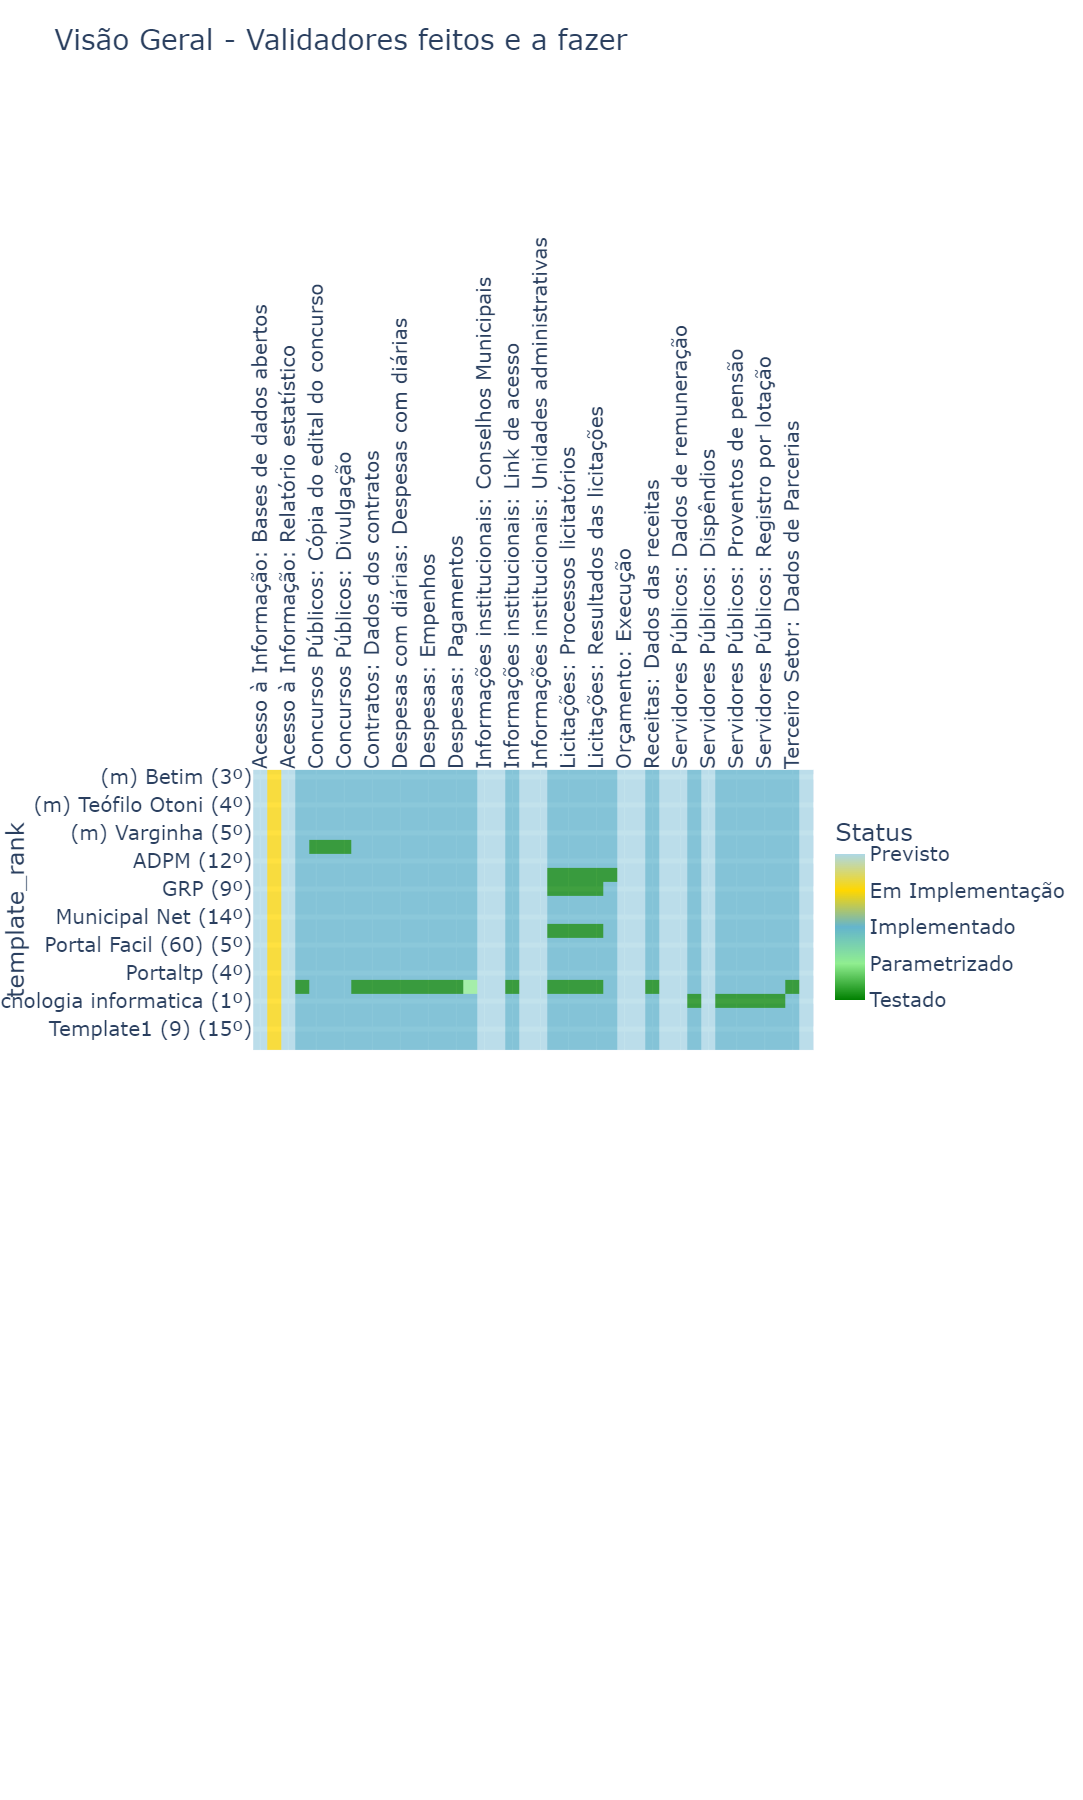

In [7]:
import plotly.express as px
import matplotlib.pyplot as plt

def plot_status_epics_dev(df, title, y_column, x_column, hue, showlegend=True):    

    fig = px.imshow(
        df, height=1800, width=1700, title=title,
        color_continuous_scale=[(0, "green"), (0.25, 'lightgreen'), (0.5, "#64b5cd"), 
                                (0.75, '#FFD700'), (1, 'lightblue')]
    )     
        
    fig.update_traces(opacity=0.75)
    fig.update_xaxes(tickangle=-90, side="top")
    fig.update_yaxes(showgrid=True, gridwidth=5)
    
    fig.update_layout(
        coloraxis_colorbar=dict(
            title="Status", 
            tickvals=[1,2,3,4,5],
            ticktext=["Testado","Parametrizado","Implementado","Em Implementação",'Previsto'],
            lenmode="pixels", 
            len=200), 
        font=dict(size=20)
    )
    
    return fig

#-----------------------------------------------------------------------

figures.plot_status_epics_dev = plot_status_epics_dev

epics_dev_df = pd.read_csv("data/epics_dev.csv", index_col="template_rank")

fig = figures.plot_status_epics_dev(epics_dev_df, title='Visão Geral - Validadores feitos e a fazer',        
        y_column='template', x_column='title', hue="state", showlegend=True)


fig.write_image('./fig/status-dev.png')#, scale=1)
fig